In [1]:
# -----------------------  Validation curves  --------------------
import numpy as np
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [2]:
# Le signal non bruité est une sinusoide.
def model(x):
    y = np.sin(x)
    return y

In [3]:
# Génération des données à modéliser
np.random.seed(43)

# Niveau de bruit gaussien
sigma = 0.2

# Génération de données non bruitées à utiliser comme signal de référence.
x_min = 0
x_max = 10
xx = np.linspace(x_min,x_max,100)[:,np.newaxis]
yy = model(xx)

# Fontion générant des données bruitées distribuées aléatoirement en x
def generate_data(N):
    x = np.random.uniform(x_min,x_max,N)
    y = model(x) + np.random.normal(0.0, sigma, N)

    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return x, y

# Génération des données. Ne pas utiliser trop de données car les fits deviennent de plus en plus semblables
N = 20
#N = 10
X,y = generate_data(N)

In [4]:
# Calcul de la relation MSE = Biais^2 + variance en fonction du degré du polynôme d'approximation 

# Données idéales, non bruitées
y_true = model(X)

# Pour chaque valeur de degré, on génère n_rep copies du signal bruité pour lequel on calcule le bias, 
# la variance et la mse des erreurs de fit
n_rep = 1000
n_degres = 16
degres = range(n_degres)

hx = np.zeros((N,n_rep))
biais2 = np.zeros(n_degres)
variance = np.zeros(n_degres)
mse = np.zeros(n_degres)

for degre in degres:
    sum = 0
    for n in range(n_rep):
        # Génère un signal bruité
        y = y_true + np.random.normal(0.0, sigma, N).reshape(-1,1)
        
        # Calcule la valeur prédite par le fit utilisant le signal bruité
        y_pred = PolynomialRegression(degre).fit(X, y).predict(X)
        hx[:,n] = np.squeeze(y_pred,axis=1)

        # Calcule la somme des carrés des erreurs de fit
        sum += np.square(y_pred - y_true).mean()
        
    # Signal moyen prédit pour un polynôme de degré donné
    E_hx = np.mean(hx,1).reshape(-1,1)

    biais2[degre] = np.square(E_hx-y_true).mean() 
    variance[degre] = np.square(E_hx-hx).mean()
    mse[degre] = sum/n_rep
               

In [5]:
# Trouve le degré du polynôme pour lequel la MSE est minimale.
indx = np.argmin(mse)
degre_opt = degres[indx]

y_pred_opt = PolynomialRegression(degre_opt).fit(X, y).predict(xx)

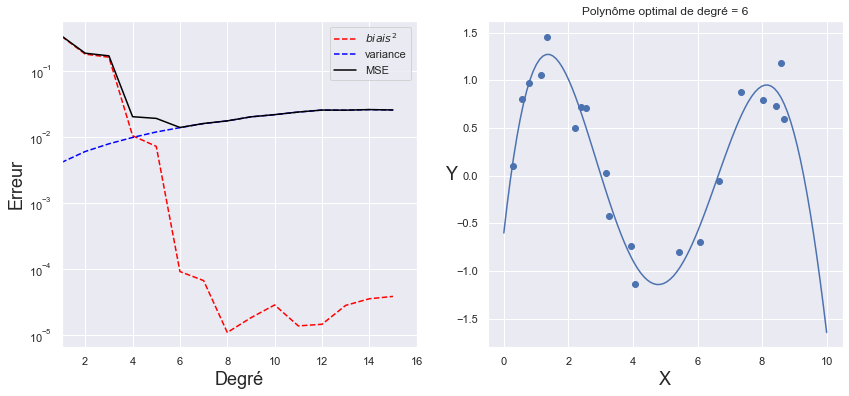

In [6]:
# Affiche la relation MSE = Biais^2 + variance en fonction du degré du polynôme d'approximation
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6))

ax1.plot(degres, biais2, color='red', label='$biais^{2}$',linestyle='--')
ax1.plot(degres, variance, color='blue', label='variance',linestyle='--')
ax1.plot(degres, mse, color='black', label='MSE')
ax1.legend(loc='best')
ax1.set_xlabel('Degré',fontsize=18)
ax1.set_ylabel('Erreur',fontsize=18)
ax1.set_xlim([1,n_degres])
ax1.set_yscale('log')

# Affiche le fit optimal, c.-à-d. celui minimisant la MSE
ax2.scatter(X.ravel(), y)
lim = plt.axis()
ax2.plot(xx, y_pred_opt);
ax2.set_xlabel('X',fontsize=18)
ax2.set_ylabel('Y',rotation=0,fontsize=18)
ax2.set_title('Polynôme optimal de degré = %d' % (degre_opt));

plt.savefig('Figure_27_29.svg', format='svg')

In [7]:
# Calcule la MSE pour les données d'entrainement et celles de test, en fonction du degré du polynôme d'approximation
N = 50
n_rep = 1000

mse_train = np.zeros(n_degres)
mse_test = np.zeros(n_degres)

for degre in degres:
    sum_train, sum_test = 0,0
    for n in range(n_rep):
        # Génère les deux ensembles de données
        X_train, y_train = generate_data(N)
        X_test, y_test = generate_data(N)
        
        # Calcule le modèle de régression en utilisant les données d'entrainement
        reg = PolynomialRegression(degre).fit(X_train, y_train)
            
        # Calcule la somme des carrés des erreurs de fit sur les données d'entrainement
        y_pred = reg.predict(X_train)
        y_true = model(X_train)
        sum_train += np.square(y_pred - y_true).mean()

        # Calcule la somme des carrés des erreurs de fit sur les données de tet
        y_pred = reg.predict(X_test)
        y_true = model(X_test)
        sum_test += np.square(y_pred - y_true).mean()
        
    mse_train[degre] = sum_train/n_rep
    mse_test[degre] = sum_test/n_rep

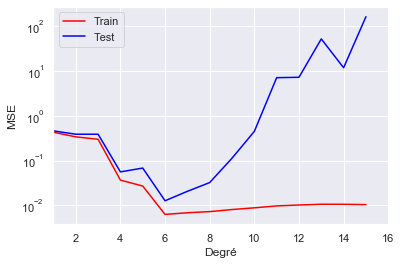

In [8]:
# Compare la MSE pour les données d'entrainement et celles de test.
plt.plot(degres, mse_train, color='red', label='Train')
plt.plot(degres, mse_test, color='blue', label='Test')
plt.legend(loc='best')
plt.xlabel('Degré')
plt.ylabel('MSE')
plt.xlim([1,n_degres])
plt.yscale('log')

plt.savefig('Figure_28_29.svg', format='svg')

In [9]:
# Fonction affichant les données originales et le modèle original
def plot_data(ax):
    ax.scatter(X, y, color='black')
    ax.plot(xx,yy);   
    ax.plot([xx.min(), xx.max()],[0, 0], color='black',linestyle='--')
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('X',fontsize=14)
    ax.set_ylabel('Y',rotation=0,fontsize=14)
    ax.set_title('Données originales')
    
# Fonction affichant plusieurs fits pour un valeur donnée de degré de polynôme 
def fit_poly(degre,N,ax):
    n_rep = 5
    for n in range(n_rep):
        X, y = generate_data(N)
        y_pred = PolynomialRegression(degre).fit(X, y).predict(xx)
        ax.plot(xx,y_pred);   
    
    ax.plot([xx.min(), xx.max()],[0, 0], color='black',linestyle='--')
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('X',fontsize=14)
    ax.set_ylabel('Y',rotation=0,fontsize=14)
    ax.set_title('Polynômes de degré = %d' % (degre))
    

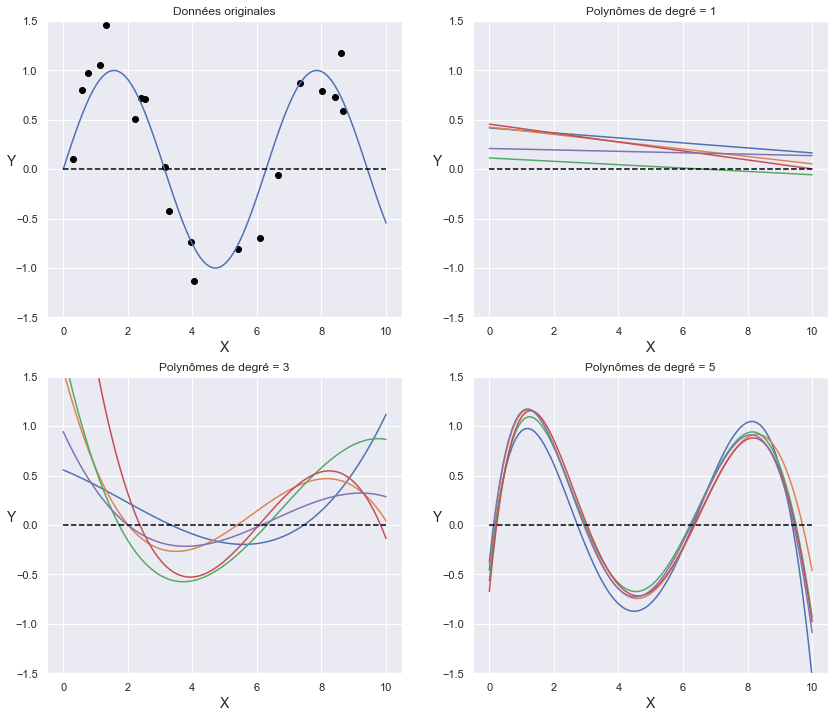

In [10]:
# Affiche plusieurs fits pour quelques valeurs de degré de polynôme 
N = 50
n_rep = 5
degre = [1, 3, 5]

fig, axes = plt.subplots(2, 2,figsize=(14, 12))
plot_data(axes[0,0])
fit_poly(degre[0],N,axes[0,1])
fit_poly(degre[1],N,axes[1,0])
fit_poly(degre[2],N,axes[1,1])

plt.savefig('Figure_26_29.svg', format='svg')